###Colab setup & dependencies

In [15]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

###Mount google drive for the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path to ZIP file in Drive
zip_path = "/content/drive/MyDrive/dataset/ML Project Dataset/Red Lentil.zip"

Mounted at /content/drive


###Unzip the file

In [3]:
!unzip -q "$zip_path" -d /content/

###Create train/val/test split

In [4]:
import os, glob, random
from pathlib import Path
random.seed(42)

SRC = '/content/Red Lentil'   # Data path which contains 'good' and 'bad'
OUT = '/content/Red Lentil Split'  # Will be created

ratios = (0.7, 0.15, 0.15)  # train, val, test

for cls in ['good','bad']:
    src_dir = os.path.join(SRC, cls)
    imgs = glob.glob(os.path.join(src_dir, '*'))
    random.shuffle(imgs)
    n = len(imgs)
    ntrain = int(n * ratios[0])
    nval = int(n * ratios[1])
    train_files = imgs[:ntrain]
    val_files = imgs[ntrain:ntrain+nval]
    test_files = imgs[ntrain+nval:]
    for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        out_dir = os.path.join(OUT, split, cls)
        os.makedirs(out_dir, exist_ok=True)
        for f in files:
            fname = os.path.basename(f)
            shutil.copy(f, os.path.join(out_dir, fname))

print("Done. Created dataset under:", OUT)
DATA_DIR = OUT

Done. Created dataset under: /content/Red Lentil Split


###Create tf.data pipelines + augmentation

In [5]:
import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = (224, 224)   # good default for these models
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    seed=42,
    shuffle=False
)

# Prefetch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Simple augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
])


Found 742 files belonging to 2 classes.
Found 159 files belonging to 2 classes.
Found 161 files belonging to 2 classes.


###Utility: build model function (transfer learning)

In [6]:
def build_transfer_model(base_model_name, input_shape=IMG_SIZE+(3,), n_classes=1, base_trainable=False):
    """
    base_model_name: one of 'EfficientNetB0', 'MobileNetV3Large', 'ResNet50V2'
    base_trainable: whether to unfreeze base for fine-tuning
    """
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    if base_model_name == 'EfficientNetB0':
        preproc = tf.keras.applications.efficientnet.preprocess_input
        base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=input_shape, weights='imagenet')
    elif base_model_name == 'MobileNetV3Large':
        preproc = tf.keras.applications.mobilenet_v3.preprocess_input
        base = tf.keras.applications.MobileNetV3Large(include_top=False, input_shape=input_shape, weights='imagenet')
    elif base_model_name == 'ResNet50V2':
        preproc = tf.keras.applications.resnet_v2.preprocess_input
        base = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape, weights='imagenet')
    else:
        raise ValueError("Unknown model")

    x = layers.Lambda(preproc)(x)
    x = base(x, training=False)   # keep batchnorm in inference mode when base frozen
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(n_classes, activation='sigmoid')(x)  # binary
    model = keras.Model(inputs, outputs)

    # Freeze or unfreeze base as requested
    base.trainable = base_trainable

    return model, base


###Training helper (freeze-then-finetune)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def compile_and_train(model, train_ds, val_ds, lr=1e-3, epochs=10, model_name='model'):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        ModelCheckpoint(f"{model_name}.h5", save_best_only=True, monitor='val_loss')
    ]
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    return history


Train three models (steps to run sequentially)

In [8]:
# 1) EfficientNetB0
model_e, base_e = build_transfer_model('EfficientNetB0', base_trainable=False)
print(model_e.summary())
history_e = compile_and_train(model_e, train_ds, val_ds, lr=1e-3, epochs=12, model_name='effnetb0_stage1')

# Fine-tune: unfreeze last some layers
base_e.trainable = True
# Optionally freeze first layers and unfreeze last block
for layer in base_e.layers[:-30]:
    layer.trainable = False
for layer in base_e.layers[-30:]:
    layer.trainable = True

history_e_ft = compile_and_train(model_e, train_ds, val_ds, lr=1e-5, epochs=8, model_name='effnetb0_finetune')


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

None
Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.7420 - loss: 0.4886

24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.7463 - loss: 0.4825 - val_accuracy: 0.9371 - val_loss: 0.1920 - learning_rate: 0.0010
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9653 - loss: 0.1373 - val_accuracy: 0.8931 - val_loss: 0.2208 - learning_rate: 0.0010
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9712 - loss: 0.0943

24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9709 - loss: 0.0940 - val_accuracy: 0.9748 - val_loss: 0.1087 - learning_rate: 0.0010
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9715 - loss: 0.0745 - val_accuracy: 0.9119 - val_loss: 0.2037 - learning_rate: 0.0010
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9837 - loss: 0.0636 - val_accuracy: 0.9057 - val_loss: 0.2307 - learning_rate: 0.0010
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9897 - loss: 0.0480 - val_accuracy: 0.7987 - val_loss: 0.4491 - learning_rate: 0.0010
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9729 - loss: 0.0682 - val_accuracy: 0.9371 - val_loss: 0.1691 - learning_rate: 5.0000e-04
Epoch 8/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9810 - loss: 0.0427 - val_accuracy: 0.9371 - val_loss: 0.1651 - learning_rate: 5.0000e-04
Epoch 1/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8091 - loss: 0.4121

24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8096 - loss: 0.4123 - val_accuracy: 0.9748 - val_loss: 0.1204 - learning_rate: 1.0000e-05
Epoch 2/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.9091 - loss: 0.2939

24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9091 - loss: 0.2934 - val_accuracy: 0.9748 - val_loss: 0.1053 - learning_rate: 1.0000e-05
Epoch 3/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9173 - loss: 0.2437

24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9177 - loss: 0.2431 - val_accuracy: 0.9748 - val_loss: 0.0990 - learning_rate: 1.0000e-05
Epoch 4/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9416 - loss: 0.2117 - val_accuracy: 0.9686 - val_loss: 0.1097 - learning_rate: 1.0000e-05
Epoch 5/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9419 - loss: 0.1853 - val_accuracy: 0.9686 - val_loss: 0.1208 - learning_rate: 1.0000e-05
Epoch 6/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9534 - loss: 0.1583 - val_accuracy: 0.9623 - val_loss: 0.1265 - learning_rate: 1.0000e-05
Epoch 7/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9489 - loss: 0.1600 - val_accuracy: 0.9371 - val_loss: 0.1451 - learning_rate: 5.0000e-06
Epoch 8/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9530 - loss: 0.1698 - val_accuracy: 0.9245 - val_loss: 0.1710 - learning_rate: 5.0000e-06


In [9]:
# 2) MobileNetV3Large
model_m, base_m = build_transfer_model('MobileNetV3Large', base_trainable=False)
history_m = compile_and_train(model_m, train_ds, val_ds, lr=1e-3, epochs=12, model_name='mobilenetv3_stage1')

base_m.trainable = True
for layer in base_m.layers[:-30]:
    layer.trainable = False
history_m_ft = compile_and_train(model_m, train_ds, val_ds, lr=1e-5, epochs=8, model_name='mobilenetv3_finetune')

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.7797 - loss: 0.4869

24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7835 - loss: 0.4791 - val_accuracy: 0.9686 - val_loss: 0.1043 - learning_rate: 0.0010
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9463 - loss: 0.1361 - val_accuracy: 0.8616 - val_loss: 0.3719 - learning_rate: 0.0010
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9804 - loss: 0.0580 - val_accuracy: 0.9560 - val_loss: 0.1128 - learning_rate: 0.0010
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9776 - loss: 0.0677 - val_accuracy: 0.9623 - val_loss: 0.1203 - learning_rate: 0.0010
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9906 - loss: 0.0380

24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9905 - loss: 0.0381 - val_accuracy: 0.9748 - val_loss: 0.0806 - learning_rate: 5.0000e-04
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9856 - loss: 0.0381

24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9857 - loss: 0.0381 - val_accuracy: 0.9811 - val_loss: 0.0425 - learning_rate: 5.0000e-04
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9898 - loss: 0.0423 - val_accuracy: 0.9811 - val_loss: 0.0717 - learning_rate: 5.0000e-04
Epoch 8/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9900 - loss: 0.0377 - val_accuracy: 0.9748 - val_loss: 0.0858 - learning_rate: 5.0000e-04
Epoch 9/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9866 - loss: 0.0373 - val_accuracy: 0.9874 - val_loss: 0.0539 - learning_rate: 5.0000e-04
Epoch 10/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9820 - loss: 0.0439 - val_accuracy: 0.9811 - val_loss: 0.0633 - learning_rate: 2.5000e-04
Epoch 11/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9921 - loss: 0.0205 - val_accuracy: 0.9748 - val_loss: 0.0817 - learning_rate: 2.5000e-04
Epoch 1/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6192 - loss: 0.7420

24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6209 - loss: 0.7393 - val_accuracy: 0.9874 - val_loss: 0.0268 - learning_rate: 1.0000e-05
Epoch 2/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8472 - loss: 0.3545 - val_accuracy: 0.9937 - val_loss: 0.0291 - learning_rate: 1.0000e-05
Epoch 3/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9321 - loss: 0.1940 - val_accuracy: 0.9874 - val_loss: 0.0335 - learning_rate: 1.0000e-05
Epoch 4/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9578 - loss: 0.1373 - val_accuracy: 0.9874 - val_loss: 0.0356 - learning_rate: 1.0000e-05
Epoch 5/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9671 - loss: 0.1189 - val_accuracy: 0.9874 - val_loss: 0.0346 - learning_rate: 5.0000e-06
Epoch 6/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9599 - loss: 0.1201 - val_accuracy: 0.9874 - val_loss: 0.0340 - learning_rate: 5.0000e-06


In [10]:
# 3) ResNet50V2
model_r, base_r = build_transfer_model('ResNet50V2', base_trainable=False)
history_r = compile_and_train(model_r, train_ds, val_ds, lr=1e-3, epochs=12, model_name='resnet50v2_stage1')

base_r.trainable = True
for layer in base_r.layers[:-30]:
    layer.trainable = False
history_r_ft = compile_and_train(model_r, train_ds, val_ds, lr=1e-5, epochs=8, model_name='resnet50v2_finetune')


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8433 - loss: 0.3325

24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8464 - loss: 0.3263 - val_accuracy: 0.9623 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 2/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9727 - loss: 0.0637

24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9729 - loss: 0.0634 - val_accuracy: 0.9874 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 3/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9802 - loss: 0.0530

24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9802 - loss: 0.0531 - val_accuracy: 0.9937 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 4/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9740 - loss: 0.0572 - val_accuracy: 0.9182 - val_loss: 0.1887 - learning_rate: 0.0010
Epoch 5/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9909 - loss: 0.0268

24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9908 - loss: 0.0271 - val_accuracy: 0.9937 - val_loss: 0.0223 - learning_rate: 0.0010
Epoch 6/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9804 - loss: 0.0467 - val_accuracy: 0.9874 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 7/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9798 - loss: 0.0504 - val_accuracy: 0.9748 - val_loss: 0.0462 - learning_rate: 0.0010
Epoch 8/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9823 - loss: 0.0380 - val_accuracy: 0.9434 - val_loss: 0.1337 - learning_rate: 0.0010
Epoch 9/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9858 - loss: 0.0480 - val_accuracy: 0.9811 - val_loss: 0.0410 - learning_rate: 5.0000e-04
Epoch 10/12
24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9893 - loss: 0.0287 - val_accuracy: 0.9874 - val_loss: 0.0321 - learning_rate: 5.0000e-04
Epoch 1/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8194 - loss: 0.4997

24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.8222 - loss: 0.4925 - val_accuracy: 0.9308 - val_loss: 0.2512 - learning_rate: 1.0000e-05
Epoch 2/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9926 - loss: 0.0441

24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9923 - loss: 0.0445 - val_accuracy: 0.9497 - val_loss: 0.1763 - learning_rate: 1.0000e-05
Epoch 3/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9903 - loss: 0.0409

24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9902 - loss: 0.0408 - val_accuracy: 0.9748 - val_loss: 0.0798 - learning_rate: 1.0000e-05
Epoch 4/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9938 - loss: 0.0252

24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9937 - loss: 0.0253 - val_accuracy: 0.9811 - val_loss: 0.0536 - learning_rate: 1.0000e-05
Epoch 5/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9922 - loss: 0.0315

24/24 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9922 - loss: 0.0316 - val_accuracy: 0.9874 - val_loss: 0.0405 - learning_rate: 1.0000e-05
Epoch 6/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9998 - loss: 0.0172

24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9997 - loss: 0.0174 - val_accuracy: 0.9937 - val_loss: 0.0350 - learning_rate: 1.0000e-05
Epoch 7/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9879 - loss: 0.0351

24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9880 - loss: 0.0348 - val_accuracy: 0.9937 - val_loss: 0.0212 - learning_rate: 1.0000e-05
Epoch 8/8
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9895 - loss: 0.0359

24/24 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9896 - loss: 0.0356 - val_accuracy: 0.9937 - val_loss: 0.0172 - learning_rate: 1.0000e-05


###Evaluation on test set (metrics & confusion matrix)

In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

def eval_model(model, test_ds):
    y_true = []
    y_prob = []
    for x, y in test_ds:
        probs = model.predict(x).ravel()
        y_prob.extend(probs.tolist())
        y_true.extend(y.numpy().tolist())
    y_pred = [1 if p >= 0.5 else 0 for p in y_prob]
    print(classification_report(y_true, y_pred, target_names=['bad','good']))
    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc, "AUC:", auc)
    return dict(acc=acc, auc=auc, cm=cm, y_true=y_true, y_pred=y_pred, y_prob=y_prob)

res_e = eval_model(model_e, test_ds)
res_m = eval_model(model_m, test_ds)
res_r = eval_model(model_r, test_ds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
              precision    recall  f1-score   support

         bad       0.91      1.00      0.95        78
        good       1.00      0.90      0.95        83

    accuracy                           0.95       161
   macro avg       0.95      0.95      0.95       161
weighted avg       0.95      0.95      0.95       161

Accuracy: 0.9503105590062112 AUC: 0.9990732159406858
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

         bad       1.00      0.99      0.99        78
        good       0.99      1.00      0.99        83



1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

         bad       1.00      1.00      1.00        78
        good       1.00      1.00      1.00        83

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161

Accuracy: 1.0 AUC: 1.0


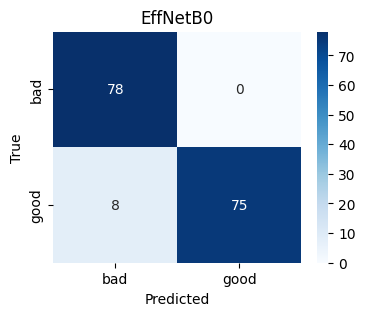

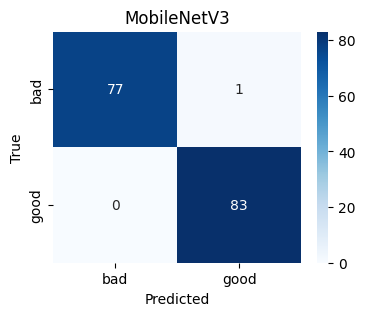

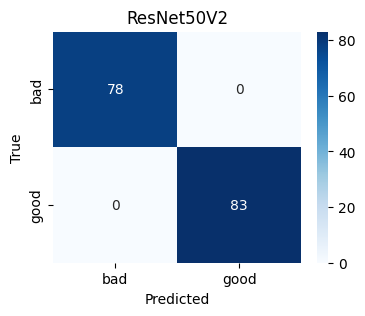

In [12]:
import seaborn as sns
def plot_cm(cm, title):
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['bad','good'], yticklabels=['bad','good'])
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title)
    plt.show()

plot_cm(res_e['cm'], 'EffNetB0')
plot_cm(res_m['cm'], 'MobileNetV3')
plot_cm(res_r['cm'], 'ResNet50V2')


###Compare models (table + ROC curves)

              model  accuracy       auc
2        ResNet50V2  1.000000  1.000000
1  MobileNetV3Large  0.993789  1.000000
0    EfficientNetB0  0.950311  0.999073


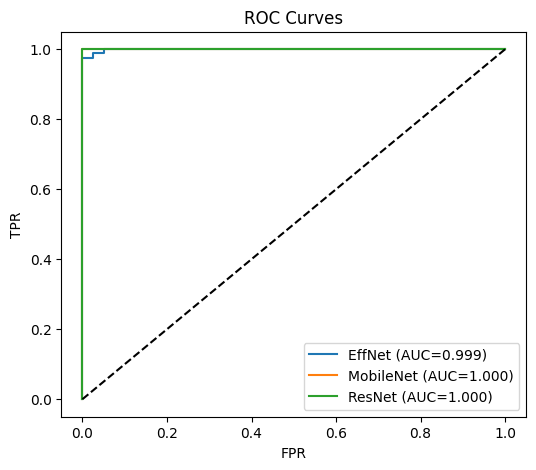

In [13]:
import pandas as pd

compare = pd.DataFrame([
    {'model':'EfficientNetB0','accuracy':res_e['acc'],'auc':res_e['auc']},
    {'model':'MobileNetV3Large','accuracy':res_m['acc'],'auc':res_m['auc']},
    {'model':'ResNet50V2','accuracy':res_r['acc'],'auc':res_r['auc']},
])
print(compare.sort_values('accuracy', ascending=False))

# ROC curves
plt.figure(figsize=(6,5))
for label, res in [('EffNet', res_e), ('MobileNet', res_m), ('ResNet', res_r)]:
    fpr, tpr, _ = roc_curve(res['y_true'], res['y_prob'])
    plt.plot(fpr, tpr, label=f"{label} (AUC={res['auc']:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves'); plt.legend()
plt.show()
